# Figure 5: Spatial Frequency RMSE

## Manuscript Information
 
"Active Mutual Conjoint Estimation of Multiple Contrast Sensitivity
Functions"
Dom CP Marticorena, Quinn Wai Wong, Jake Browning, Ken Wilbur, Pinakin Davey, Aaron R. Seitz, Jacob R. Gardner, Dennis L. Barbour
_Journal of Vision_

[link to paper or preprint]

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis

## Figure Description

Mean ± standard deviation RMSE errors in cycles per degree of a (Normal, Normal) phenotype pair,
averaged from 10 repeat experiments using 100 samples per phenotype. Data sources were first-generation disjoint
MLCRF (green), first-generation conjoint MLCRF (purple), second-generation disjoint MLCRF (blue), and second-
generation conjoint MLCRF (red). Data were actively sampled across both members of the (Normal, Normal) pair.

## References

[references]


### Imports

In [1]:
# Import libraries
import os
import sys
import torch
import gpytorch as gp

import math
import numpy as np

import datetime
import json
import pickle
import tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# need access to root directory to import utils
parent_dir = os.path.dirname(os.path.abspath(''))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utility.utils import *
from QuickCSF import QuickCSF, simulate

### Check versions

In [2]:
print("python version -->>", sys.version.split(" ")[0], "(expected 3.10.9)")
print("gpytorch version -->>", gp.__version__, "(expected 1.8.1)")
print("pytorch version -->>", torch.__version__, "(expected 1.13.1)")

python version -->> 3.10.9 (expected 3.10.9)
gpytorch version -->> 1.8.1 (expected 1.8.1)
pytorch version -->> 1.13.1 (expected 1.13.1)


### Run-time flags

In [3]:
train_mode = False          # create new data? Set to false if plotting existing results
verbose_mode = False        # print verbose analyses?
scrn_mode = True            # plot on screen?
save_results_mode = True    # save results to file?
save_plots_mode = True      # save plots to directory?

### Variables

In [4]:
# enums
NORMAL, CATARACTS, MILD_AMBLYOPIA, MULTIPLE_SCLEROSIS = ['Normal', 'Cataracts', 'Mild Amblyopia', 'Multiple Sclerosis']

# tasks and number of latents
phenotypes = [NORMAL, NORMAL]
num_latents = 2
sampling_method = 'alternating'     # 'alternating' or 'unconstrained'
weight_decay = 1e-4

# choose to run multiple experiments with preset random seeds
# or a single experiment specifying your own random seeds
run_multiple_experiments = True

# number of samples
num_halton_samples_per_task = 2
num_new_pts_per_task = 98

# choosing which figures to make
make_gp_gifs = True

# directory to save plots and results
# will save to the path <save_dir_prefix>/<current_timestamp>
save_dir_prefix = 'analysis/Figure05'

# Individual print flags
print_training_hyperparameters = False
print_training_iters = False
print_progress_bar = False

# Set all to true if verbose_mode
if verbose_mode:
    print_training_hyperparameters = False
    print_training_iters = True
    print_progress_bar = False

# Create the bounds for the data
raw_freq_min = 1
raw_freq_max = 64
raw_contrast_min = 1e-3
raw_contrast_max = 1

# Define how to transform the data
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # max and min get flipped when inverting
y_max = logContrast().forward(raw_contrast_min)

# transform the data
def normalize_to_unit_range(d):
    return scale_data_within_range(d, (0, 1), x_min, x_max, y_min, y_max)

# marginal log resolutions of evaulation grid
x_resolution = 15  # 15 spatial frequencies per octave
y_resolution = 30  # 30 contrast units per decade

# for computing the proper prior threshold curve
psi_gamma  = 0.04  # guess rate is 4%
psi_lambda = 0.04 # lapse rate is 4%
psi_sigma = 0.08
sigmoid_type = 'logistic'

# training parameters
num_initial_points_training_iters = 500
num_new_points_training_iters = 150
train_on_all_points_iters = 1500
sampling_strategy = 'active'
mean_module = 'constant_mean'
train_on_all_points_after_sampling = False
calculate_rmse = True
calculate_posterior = True
calculate_entropy = True

# GP hyperparameters
learning_rate = .125
beta_for_regularization = .5
min_lengthscale = .15 # Note this changed from .2

# Set raw ghost points
raw_ghost_frequency = np.array([1, 2, 4, 8, 16, 32, 64, 128])
raw_ghost_contrast = np.array([5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1])


### Timestamp

In [5]:
# get current timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = f"{save_dir_prefix}/{timestamp}/"
print(f"Saving to... {save_dir}")

Saving to... analysis/Figure05/2024-05-14_16-31-27/


### Automatically calculated variables

In [6]:
# create common variables shared among all tasks
grid, xx, yy, xs, ys = create_evaluation_grid_resolution(
        x_min, x_max, y_min, y_max, x_resolution, y_resolution)

grid_transformed = transform_dataset(grid, phi=normalize_to_unit_range)

# function to get ground truth curves
def get_spline(curve):
    curve = np.array(curve)
    curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
    cs = create_cubic_spline(curve)
    return cs


# get data selection
exp1_file = '../data/raw/csf_curves_exp1.json'
csf_curves_exp1 = load_json_from_file(exp1_file)
all_phenotypes = {MULTIPLE_SCLEROSIS: csf_curves_exp1['multiple_sclerosis'],
             CATARACTS: csf_curves_exp1['cataracts'],
             NORMAL: csf_curves_exp1['normal'],
             MILD_AMBLYOPIA: csf_curves_exp1['mild_amblyopia']}

phenotype_pair = [(pheno, all_phenotypes[pheno]) for pheno in phenotypes]


num_tasks = len(phenotype_pair)

ground_truths = [get_spline(pheno_data) for _, pheno_data in phenotype_pair]

# get number of actively learned points for disjoint vs conjoint
num_new_conjoint_pts = num_new_pts_per_task * num_tasks

# create ghost points and labels
ghost_x1 = logFreq().forward(raw_ghost_frequency)
ghost_x2 = logContrast().forward(raw_ghost_contrast)
assert len(ghost_x1) == len(ghost_x2), "x1 and x2 have diff lengths"

ghost_X = np.vstack((ghost_x1, ghost_x2)).T
ghost_y = np.array([0]*len(ghost_x2))

# create disjoint initial primer points
halton_X = get_halton_samples(xx, yy, num_halton_samples_per_task)
initial_disjoint_X = np.vstack((ghost_X, halton_X))

# create conjoint initial primer points and task indices
# simulated Halton y labels are created later for each experiment
halton_Xs = np.repeat(halton_X, num_tasks, axis=0)

num_ghost_points_per_task = len(ghost_y)
halton_task_indices = torch.arange(num_tasks).tile((num_halton_samples_per_task))

ghost_Xs = np.tile(ghost_X, (num_tasks, 1))
ghost_ys = np.tile(ghost_y, num_tasks)
ghost_task_indices = torch.arange(num_tasks).repeat_interleave(num_ghost_points_per_task)

num_disjoint_ghost_points = len(ghost_x2)
num_conjoint_ghost_points = len(ghost_task_indices)

# create initial dataset using ghost and halton samples
initial_Xs = np.vstack((ghost_Xs, halton_Xs))
initial_task_indices = torch.cat((ghost_task_indices, halton_task_indices))

# random seed lists for single vs multiple rounds
if run_multiple_experiments:
    num_exps = 10
    # unique random seeds for halton samples and training
    primer_seeds_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
    gp_seed_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
else:
    num_exps = 1
    primer_seeds_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
    gp_seed_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]

### Training

In [7]:
    

if train_mode:
    
    
    figure_dict = {
        "tasks": phenotypes,
        "num_latents": num_latents,
        "sampling_method": sampling_method,
        "num_exps": num_exps,
        "num_halton_samples_per_task": num_halton_samples_per_task,
        "num_new_pts_per_task": num_new_pts_per_task,
        "raw_freq_min": raw_freq_min,
        "raw_freq_max": raw_freq_max,
        "raw_contrast_min": raw_contrast_min,
        "raw_contrast_max": raw_contrast_max,
        "x_resolution": x_resolution,
        "y_resolution": y_resolution,
        "raw_ghost_frequency": raw_ghost_frequency.tolist(),
        "raw_ghost_contrast": raw_ghost_contrast.tolist(),
        "primer_seeds_list": primer_seeds_list,
        "gp_seed_list": gp_seed_list,
        "weight_decay": weight_decay,
        "min_lengthscale": min_lengthscale,
        "psi_sigma": psi_sigma,
        "sigmoid_type": sigmoid_type,
        "psi_gamma": psi_gamma,
        "psi_lambda": psi_lambda,
        "lr": learning_rate,
        "num_initial_training_iters": num_initial_points_training_iters,
        "num_new_points_training_iters": num_new_points_training_iters,
        "beta_for_regularization": beta_for_regularization,
        "train_on_all_points_after_sampling": train_on_all_points_after_sampling,
        "print_training_hyperparameters": print_training_hyperparameters,
        "print_training_iters": print_training_iters,
        "progress_bar": print_progress_bar,
        "calculate_rmse": calculate_rmse,
        "calculate_entropy": calculate_entropy,
        "calculate_posterior": calculate_posterior
    }

    ensure_directory_exists(save_dir)
    with open(save_dir + "run_configs.json", 'w') as file:
        json.dump(figure_dict, file, indent=2)






    # disjoint

    disjoint_results_dicts = [{} for _ in range(num_tasks)]
    disjoint_gp_lists = []

    for exp in range(num_exps):
        print(f"Experiment {exp}")

        # get unique random seeds for each exp
        primer_seeds = primer_seeds_list[exp]
        gp_seeds = gp_seed_list[exp]

        for i, (pheno, _) in enumerate(phenotype_pair):
            print(pheno)

            cs = ground_truths[i]
            primer_seed = primer_seeds[i]
            gp_seed = gp_seeds[i]

            # get initial primer labels
            set_random_seed(primer_seed)
            halton_y = simulate_labeling(halton_X[:, 0], halton_X[:, 1], cs, 0, 0, sigmoid_type=sigmoid_type,
                                         psi_sigma=psi_sigma)  # changed  psi_gamma, psi_lambda to 0, 0
            initial_y = np.hstack((ghost_y, halton_y))

            # run active learning
            set_random_seed(gp_seed)

            model, likelihood, X, y, rmse_list, _, posterior_list, _ = sample_and_train_gp(
                cs,
                grid,
                xx,
                yy,
                sampling_strategy=sampling_strategy,
                mean_module_name=mean_module,
                psi_sigma=psi_sigma,
                sigmoid_type=sigmoid_type,
                psi_gamma=psi_gamma,
                psi_lambda=psi_lambda,
                lr=learning_rate,
                num_initial_training_iters=num_initial_points_training_iters,
                num_new_points_training_iters=num_new_points_training_iters,
                num_new_points=num_new_pts_per_task,
                beta_for_regularization=beta_for_regularization,
                train_on_all_points_after_sampling=train_on_all_points_after_sampling,
                train_on_all_points_iters=train_on_all_points_iters,
                phi=normalize_to_unit_range,
                print_training_hyperparameters=print_training_hyperparameters,
                print_training_iters=print_training_iters,
                progress_bar=print_progress_bar,
                min_lengthscale=min_lengthscale,
                calculate_rmse=calculate_rmse,
                calculate_entropy=calculate_entropy,
                calculate_posterior=calculate_posterior,
                initial_Xs=initial_disjoint_X,
                initial_ys=initial_y,
                num_ghost_points=num_disjoint_ghost_points,
                weight_decay=weight_decay,
                kernel_config='new',
                acq_config='new',
                error='RSE'
            )

            zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
                .reshape(xx.shape)

            disjoint_results_dicts[i][exp] = {
                'training_seed': gp_seed,
                'random_seed': primer_seed,
                'X': X,
                'y': y,
                'zz': zz,
                'rmse_list': rmse_list
            }

            gif_dict = {
                'xx': xx,
                'yy': yy,
                'X': X,
                'y': y,
                'cs': cs,
                'psi_sigma': psi_sigma,
                'sigmoid_type': sigmoid_type,
                'psi_gamma': psi_gamma,
                'psi_lambda': psi_lambda,
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'xs': xs,
                'ys': ys,
                'grid': grid,
                'f': normalize_to_unit_range,
                'posterior_list': posterior_list,
            }

            # create gif of the task
            if make_gp_gifs and save_plots_mode:
                ntitle = pheno.replace(' ', '_')
                gif_path = f'{save_dir}/task{i}_{ntitle.lower()}/{exp}/'
                ensure_directory_exists(gif_path)
                create_and_save_plots(gif_dict, gif_path, ntitle, start_index=num_disjoint_ghost_points,
                                      xticks_labels=x_tick_labels, yticks_labels=y_tick_labels)
                create_gif(gif_path)

            gp_list = [model for model, _ in posterior_list]
            disjoint_gp_lists.append(gp_list)
            print()

        if save_results_mode:
            ensure_directory_exists(save_dir)
            with open(f'{save_dir}disjoint_results.pkl', 'wb') as file:
                pickle.dump(disjoint_results_dicts, file)







    # disjoint old

    disjoint_results_dicts_old = [{} for _ in range(num_tasks)]
    disjoint_gp_lists_old = []

    for exp in range(num_exps):
        print(f"Experiment {exp}")

        # get unique random seeds for each exp
        primer_seeds = primer_seeds_list[exp]
        gp_seeds = gp_seed_list[exp]

        for i, (pheno, _) in enumerate(phenotype_pair):
            print(pheno)

            cs = ground_truths[i]
            primer_seed = primer_seeds[i]
            gp_seed = gp_seeds[i]

            # get initial primer labels
            set_random_seed(primer_seed)
            halton_y = simulate_labeling(halton_X[:, 0], halton_X[:, 1], cs, 0, 0, sigmoid_type=sigmoid_type,
                                         psi_sigma=psi_sigma)  # changed  psi_gamma, psi_lambda to 0, 0
            initial_y = np.hstack((ghost_y, halton_y))

            # run active learning
            set_random_seed(gp_seed)

            model, likelihood, X, y, rmse_list, _, posterior_list, _ = sample_and_train_gp(
                cs,
                grid,
                xx,
                yy,
                sampling_strategy=sampling_strategy,
                mean_module_name=mean_module,
                psi_sigma=psi_sigma,
                sigmoid_type=sigmoid_type,
                psi_gamma=psi_gamma,
                psi_lambda=psi_lambda,
                lr=learning_rate,
                num_initial_training_iters=num_initial_points_training_iters,
                num_new_points_training_iters=num_new_points_training_iters,
                num_new_points=num_new_pts_per_task,
                beta_for_regularization=beta_for_regularization,
                train_on_all_points_after_sampling=train_on_all_points_after_sampling,
                train_on_all_points_iters=train_on_all_points_iters,
                phi=normalize_to_unit_range,
                print_training_hyperparameters=print_training_hyperparameters,
                print_training_iters=print_training_iters,
                progress_bar=print_progress_bar,
                min_lengthscale=min_lengthscale,
                calculate_rmse=calculate_rmse,
                calculate_entropy=calculate_entropy,
                calculate_posterior=calculate_posterior,
                initial_Xs=initial_disjoint_X,
                initial_ys=initial_y,
                num_ghost_points=num_disjoint_ghost_points,
                weight_decay=weight_decay,
                kernel_config='old',
                acq_config='old',
                error='RSE'
            )

            zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
                .reshape(xx.shape)

            disjoint_results_dicts_old[i][exp] = {
                'training_seed': gp_seed,
                'random_seed': primer_seed,
                'X': X,
                'y': y,
                'zz': zz,
                'rmse_list': rmse_list
            }

            gif_dict_old = {
                'xx': xx,
                'yy': yy,
                'X': X,
                'y': y,
                'cs': cs,
                'psi_sigma': psi_sigma,
                'sigmoid_type': sigmoid_type,
                'psi_gamma': psi_gamma,
                'psi_lambda': psi_lambda,
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'xs': xs,
                'ys': ys,
                'grid': grid,
                'f': normalize_to_unit_range,
                'posterior_list': posterior_list,
            }

            # create gif of the task
            if make_gp_gifs and save_plots_mode:
                ntitle = pheno.replace(' ', '_')
                gif_path = f'{save_dir}/task{i}_{ntitle.lower()}/{exp}/'
                ensure_directory_exists(gif_path)
                create_and_save_plots(gif_dict_old, gif_path, ntitle, start_index=num_disjoint_ghost_points,
                                      xticks_labels=x_tick_labels, yticks_labels=y_tick_labels)
                create_gif(gif_path)

            gp_list = [model for model, _ in posterior_list]
            disjoint_gp_lists_old.append(gp_list)
            print()

        if save_results_mode:
            ensure_directory_exists(save_dir)
            with open(f'{save_dir}disjoint_results_old.pkl', 'wb') as file:
                pickle.dump(disjoint_results_dicts_old, file)









    # conjoint 

    conjoint_results_dicts = {}
    conjoint_gp_lists = []

    for exp in range(num_exps):
        print(f"Experiment {exp}")

        # get unique random seeds for each exp
        primer_seeds = primer_seeds_list[exp]
        gp_seed = gp_seed_list[exp][0]

        # get unique halton labels for each experiment
        halton_y_list = []

        for i, _ in enumerate(phenotype_pair):
            cs = ground_truths[i]
            set_random_seed(primer_seeds[i])
            halton_y = simulate_labeling(halton_X[:, 0], halton_X[:, 1], cs, 0, 0, sigmoid_type=sigmoid_type,
                                         psi_sigma=psi_sigma)  # changed  psi_gamma, psi_lambda to 0, 0
            halton_y_list.append(halton_y)

        # stack all task halton labels then stack ghost with halton labels
        halton_ys = np.array([y for y_per_halton in zip(*halton_y_list) for y in y_per_halton])
        initial_ys = np.hstack((ghost_ys, halton_ys))

        # run active learning
        set_random_seed(gp_seed)

        model, likelihood, X, y, task_indices, rmse_list, entropy_list, posterior_list, _ = sample_and_train_gp_conjoint(
            cs=ground_truths,
            grid=grid,
            xx=xx,
            yy=yy,
            psi_sigma=psi_sigma,
            psi_gamma=psi_gamma,
            psi_lambda=psi_lambda,
            lr=learning_rate,
            num_initial_training_iters=num_initial_points_training_iters,
            num_new_points_training_iters=num_new_points_training_iters,
            num_new_points=num_new_conjoint_pts,
            beta_for_regularization=beta_for_regularization,
            phi=normalize_to_unit_range,
            print_training_hyperparameters=print_training_hyperparameters,
            print_training_iters=print_training_iters,
            train_on_all_points_after_sampling=train_on_all_points_after_sampling,
            train_on_all_points_iters=train_on_all_points_iters,
            min_lengthscale=min_lengthscale,
            initial_Xs=initial_Xs,
            initial_ys=initial_ys,
            sampling_strategy=sampling_strategy,
            num_ghost_points=num_conjoint_ghost_points,
            calculate_rmse=calculate_rmse,
            calculate_entropy=calculate_entropy,
            calculate_posterior=calculate_posterior,
            progress_bar=print_progress_bar,
            num_tasks=num_tasks,
            num_latents=num_latents,
            task_indices=initial_task_indices,
            sampling_method=sampling_method,
            weight_decay=weight_decay,
            kernel_config='new',
            acq_config='new',
            error='RSE'
        )

        zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
            .reshape((*xx.shape, num_tasks))

        conjoint_results_dicts[exp] = {
            'training_seed': gp_seed,
            'random_seeds': primer_seeds,
            'X': X,
            'y': y,
            'zz': zz,
            'task_indices': task_indices,
            'entropy_list': entropy_list,
            'rmse_list': rmse_list
        }

        gp_list = [model for model, _ in posterior_list]
        conjoint_gp_lists.append(gp_list)
        print()

        if save_results_mode:
            ensure_directory_exists(save_dir)
            with open(f'{save_dir}conjoint_results.pkl', 'wb') as file:
                pickle.dump(conjoint_results_dicts, file)








    # conjoint old

    conjoint_results_dicts_old = {}
    conjoint_gp_lists_old = []

    for exp in range(num_exps):
        print(f"Experiment {exp}")

        # get unique random seeds for each exp
        primer_seeds = primer_seeds_list[exp]
        gp_seed = gp_seed_list[exp][0]

        # get unique halton labels for each experiment
        halton_y_list = []

        for i, _ in enumerate(phenotype_pair):
            cs = ground_truths[i]
            set_random_seed(primer_seeds[i])
            halton_y = simulate_labeling(halton_X[:, 0], halton_X[:, 1], cs, 0, 0, sigmoid_type=sigmoid_type,
                                         psi_sigma=psi_sigma)  # changed  psi_gamma, psi_lambda to 0, 0
            halton_y_list.append(halton_y)

        # stack all task halton labels then stack ghost with halton labels
        halton_ys = np.array([y for y_per_halton in zip(*halton_y_list) for y in y_per_halton])
        initial_ys = np.hstack((ghost_ys, halton_ys))

        # run active learning
        set_random_seed(gp_seed)

        model, likelihood, X, y, task_indices, rmse_list, entropy_list, posterior_list, _ = sample_and_train_gp_conjoint(
            cs=ground_truths,
            grid=grid,
            xx=xx,
            yy=yy,
            psi_sigma=psi_sigma,
            psi_gamma=psi_gamma,
            psi_lambda=psi_lambda,
            lr=learning_rate,
            num_initial_training_iters=num_initial_points_training_iters,
            num_new_points_training_iters=num_new_points_training_iters,
            num_new_points=num_new_conjoint_pts,
            beta_for_regularization=beta_for_regularization,
            phi=normalize_to_unit_range,
            print_training_hyperparameters=print_training_hyperparameters,
            print_training_iters=print_training_iters,
            train_on_all_points_after_sampling=train_on_all_points_after_sampling,
            train_on_all_points_iters=train_on_all_points_iters,
            min_lengthscale=min_lengthscale,
            initial_Xs=initial_Xs,
            initial_ys=initial_ys,
            sampling_strategy=sampling_strategy,
            num_ghost_points=num_conjoint_ghost_points,
            calculate_rmse=calculate_rmse,
            calculate_entropy=calculate_entropy,
            calculate_posterior=calculate_posterior,
            progress_bar=print_progress_bar,
            num_tasks=num_tasks,
            num_latents=num_latents,
            task_indices=initial_task_indices,
            sampling_method=sampling_method,
            weight_decay=weight_decay,
            kernel_config='old',
            acq_config='old',
            error='RSE'
        )

        zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
            .reshape((*xx.shape, num_tasks))

        conjoint_results_dicts_old[exp] = {
            'training_seed': gp_seed,
            'random_seeds': primer_seeds,
            'X': X,
            'y': y,
            'zz': zz,
            'task_indices': task_indices,
            'entropy_list': entropy_list,
            'rmse_list': rmse_list
        }

        gp_list = [model for model, _ in posterior_list]
        conjoint_gp_lists_old.append(gp_list)
        print()

        if save_results_mode:
            ensure_directory_exists(save_dir)
            with open(f'{save_dir}conjoint_results_old.pkl', 'wb') as file:
                pickle.dump(conjoint_results_dicts_old, file)

### Train QCSF

In [8]:

qcsf_results = [dict(), dict()]

for task in range(2):
    pheno_name = phenotype_pair[task][0]
    raw_ground_truth = np.array(phenotype_pair[task][1])
    ground_truth = ground_truths[task]
    print(f'Task {task}')
    
    for exp in range(num_exps): 
        print(f'Exp {exp}')
        
        seed = exp + (task * num_exps)
        set_random_seed(seed)
        print(f'Seed {seed}')
        

        simulationParams = {
            'trials': 100,
            'stimuli': {
                'minContrast': raw_contrast_min,
                'maxContrast': raw_contrast_max,
                'contrastResolution': xs,
                'minFrequency': raw_freq_min,
                'maxFrequency': raw_freq_max,
                'frequencyResolution': ys,
            },
            'parameters': None,
            'd': 1,  # guess rate used by qcsf model           
            'psiGamma': 0,
            'psiLambda': 0,
            'psiSigma': psi_sigma,
            "sigmoidType": sigmoid_type,
            'showPlots': False  # prevents plt from plotting every run 
        }

        rmses, times, params = simulate.runSimulation(
            trueThresholdCurve=raw_ground_truth,
            **simulationParams
        )        

        xmedium = xx[0, :]
        frequency = logFreq().inverse(xmedium)
        ymedium = QuickCSF.csf(params['peakSensitivity'], params['peakFrequency'], params['bandwidth'], params['delta'], frequency).reshape(-1)
        
        ytrue = ground_truth(xmedium)
        
#         print(ymedium)
#         print("HERE")
#         print(ytrue)
        
        
        
        
        qcsf_results[task][exp] = np.abs(np.array(ymedium) - np.array(ytrue))

Task 0
Exp 0
Seed 0
Estimates = {'peakSensitivity': 249.750732497389, 'peakFrequency': 10.227080354336868, 'bandwidth': 1.4236237018482696, 'delta': 50.470866951236445, 'aulcsf': 68.47550065638747}
Exp 1
Seed 1
Estimates = {'peakSensitivity': 291.47954992344745, 'peakFrequency': 7.966359710417726, 'bandwidth': 1.7839263300414219, 'delta': 97.65630341425859, 'aulcsf': 70.69712858449955}
Exp 2
Seed 2
Estimates = {'peakSensitivity': 309.01564829879896, 'peakFrequency': 7.590612631162252, 'bandwidth': 1.7496303712727086, 'delta': 91.18070929532604, 'aulcsf': 67.21418777138483}
Exp 3
Seed 3
Estimates = {'peakSensitivity': 433.58998820614744, 'peakFrequency': 7.766591060292954, 'bandwidth': 1.6691560485419359, 'delta': 222.12047521403326, 'aulcsf': 71.1994236874027}
Exp 4
Seed 4
Estimates = {'peakSensitivity': 326.1204794191397, 'peakFrequency': 7.1721403867322255, 'bandwidth': 1.8918715948359792, 'delta': 127.60960347431865, 'aulcsf': 70.10263514507074}
Exp 5
Seed 5
Estimates = {'peakSensit

In [9]:
qcsf_results[0][1]

array([3.10556351e-01, 2.84251717e-01, 2.58889305e-01, 2.34453506e-01,
       2.10928715e-01, 1.88299323e-01, 1.66549726e-01, 1.45664314e-01,
       1.25627482e-01, 1.06423623e-01, 8.80371301e-02, 7.04523958e-02,
       5.36538137e-02, 3.76257768e-02, 2.23526782e-02, 7.81891115e-03,
       5.99113132e-03, 1.90936851e-02, 3.15143412e-02, 4.32858624e-02,
       5.44411942e-02, 6.50132824e-02, 7.50350725e-02, 8.45395103e-02,
       9.35595412e-02, 1.02128111e-01, 1.10278165e-01, 1.18042649e-01,
       1.25454504e-01, 1.32528565e-01, 1.39221264e-01, 1.45477274e-01,
       1.51241267e-01, 1.56457917e-01, 1.61071897e-01, 1.43864069e-01,
       1.17201079e-01, 9.29479129e-02, 7.10492428e-02, 5.14497424e-02,
       3.40940849e-02, 1.89269434e-02, 5.89299123e-03, 5.06309842e-03,
       1.39966523e-02, 2.09629973e-02, 2.60174601e-02, 2.92371601e-02,
       3.07867328e-02, 3.08527798e-02, 2.96219026e-02, 2.72807027e-02,
       2.40157817e-02, 2.00137410e-02, 1.54611821e-02, 1.05447066e-02,
      

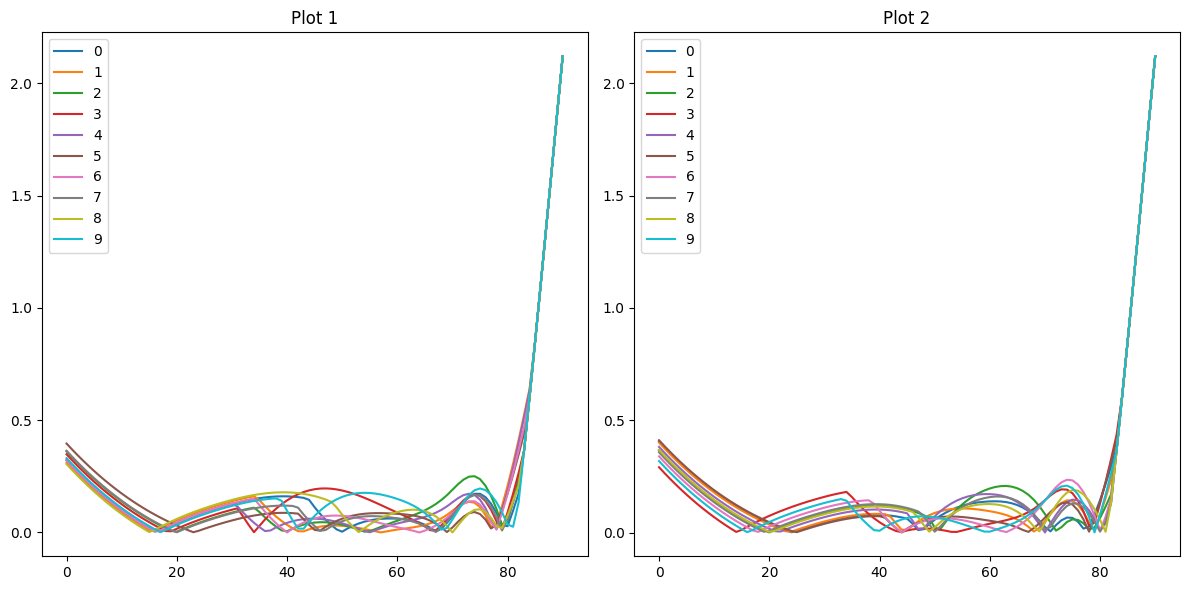

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming qcsf_results is already defined

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create two subplots

for i, results in enumerate(qcsf_results):
    ax = axs[i]
    for key, value in results.items():
        x = np.arange(len(value))  # Generate x-values as indices
        ax.plot(x, value, label=key)  # Plot the curve
    ax.legend()  # Add legend for the curves
    ax.set_title(f'Plot {i+1}')  # Set plot title

plt.tight_layout()
plt.show()


## Load data

In [11]:
# Path to saved data
# load_dir = save_dir
load_dir = "C:/Repos/delete_me/Figure05/"

# Load data from pickle files
with open(load_dir + 'conjoint_results.pkl', 'rb') as file:
    conjoint_results_dicts = pickle.load(file)

with open(load_dir + 'conjoint_results_old.pkl', 'rb') as file:
    conjoint_results_dicts_old = pickle.load(file)

with open(load_dir + 'disjoint_results.pkl', 'rb') as file:
    disjoint_results_dicts = pickle.load(file)

with open(load_dir + 'disjoint_results_old.pkl', 'rb') as file:
    disjoint_results_dicts_old = pickle.load(file)

## Create plot

### Formatting variables

In [18]:

load_dir = "D:/Repos/delete_me/Figure05/"

subplots_adjust_params = {
    'bottom':0.1,
    'top':0.9,
    'left':0.1,
    'right':0.8,
    'wspace':0.08,
    'hspace':0.3
}

figure_width = 6.5  # inches
figure_height = figure_width / 2 / 2  # inches

dpi_val = 600              # graphics resolution
plt.rcParams['font.family'] = 'sans-serif'

legend_loc = 'upper center'
legend_font_size = 5.5
tick_font_size = 6
label_font_size = 8
title_font_size = 10

x_tick_labels = [1, 4, 16, 64]
y_tick_labels = [1, 0.1, 0.01, 0.001]

x_ticks_labels = [1, 4, 16, 64]
x_ticks_values = [0, 30, 60, 90]
x_ticks_min = x_ticks_values[0]
x_ticks_max = x_ticks_values[-1]

rmse_y_ticks = np.arange(.35, step=0.05)
rmse_y_ticks_min = rmse_y_ticks[0]
rmse_y_ticks_max = rmse_y_ticks[-1]

rmse_x_label = "Spatial Frequency (cyc/deg)"
rmse_y_label = "RMSE"

DISJOINT, CONJOINT, DISJOINT_OLD, CONJOINT_OLD = "new model: disjoint", "new model: conjoint", "original model: disjoint", "original model: conjoint"

conditions = [
    (DISJOINT_OLD, disjoint_results_dicts_old, 'red'),
    (CONJOINT_OLD, conjoint_results_dicts_old, 'blue'),
    (DISJOINT, disjoint_results_dicts, 'yellow'),
    (CONJOINT, conjoint_results_dicts, 'green'),
]

std_transparency = 0.2


legend_mapping = {
    DISJOINT: '2nd gen disjoint',
    DISJOINT_OLD: '1st gen disjoint',
    CONJOINT: '2nd gen conjoint',
    CONJOINT_OLD: '1st gen conjoint'
}

mean_linewidth = 1
std_linewidth = 1

axis_tick_params = {
    'axis': 'both',
    'which': 'major',
    'direction': 'out',
    'length': 2
}

use_mean = False

filename = 'Figure05_SpatialFrequencyRMSE'


In [16]:
print(type(disjoint_results_dicts))
print(len(disjoint_results_dicts))
print(type(disjoint_results_dicts[0]))
print(disjoint_results_dicts[0].keys())
print(type(disjoint_results_dicts[0][0]))
print(disjoint_results_dicts[0][0].keys())
print(type(disjoint_results_dicts[0][0]['rmse_list']))
print(len(disjoint_results_dicts[0][0]['rmse_list']))
print(len(disjoint_results_dicts[0][0]['rmse_list'][0]))


<class 'list'>
2
<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
<class 'dict'>
dict_keys(['training_seed', 'random_seed', 'X', 'y', 'zz', 'rmse_list'])
<class 'list'>
100
82


### Plotting

<Figure size 640x480 with 0 Axes>

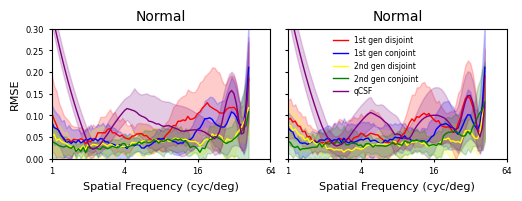

In [28]:

num_exps = len(list(conjoint_results_dicts.keys()))

# Set up plot
fig, axs = plt.subplots(1, num_tasks, figsize=(figure_width, figure_height))

# Set up subplots
for task_idx, (pheno, _) in enumerate(phenotype_pair):
    ax = axs[task_idx]
    title = pheno

    for (condition, results_dicts, color) in conditions:
        # Determine the length of the arrays in the rmse_list
        # Use the first experiment of the first condition as a reference
        reference_rmse_list = results_dicts[0]['rmse_list'][task_idx] if condition in [CONJOINT, CONJOINT_OLD] else \
        results_dicts[task_idx][0]['rmse_list']
        num_indices = len(reference_rmse_list[0])
        sample_count = np.arange(num_indices)

        if use_mean:
            # Calculate mean across all arrays
            all_rses = np.zeros((num_exps, num_indices))

            for exp_idx in range(num_exps):
                if condition in [DISJOINT, DISJOINT_OLD]:
                    rmse_list = results_dicts[task_idx][exp_idx]['rmse_list']
                elif condition in [CONJOINT, CONJOINT_OLD]:
                    rmse_list = results_dicts[exp_idx]['rmse_list'][task_idx]
                else:
                    raise Exception("not a valid condition")

                rses = np.array([rmse_array for rmse_array in rmse_list])
                all_rses[exp_idx, :] = np.mean(rses, axis=0)

            mean_rses = np.mean(all_rses, axis=0)
            std_rses = np.std(all_rses, axis=0)
        else:
            # Calculate mean across all arrays
            all_rses = np.zeros((num_exps, num_indices))

            for exp_idx in range(num_exps):
                if condition in [DISJOINT, DISJOINT_OLD]:
                    rmse_list = results_dicts[task_idx][exp_idx]['rmse_list']
                elif condition in [CONJOINT, CONJOINT_OLD]:
                    rmse_list = results_dicts[exp_idx]['rmse_list'][task_idx]
                else:
                    raise Exception("not a valid condition")

                rses = np.array([rmse_array for rmse_array in rmse_list])
                all_rses[exp_idx, :] = rses[-1]

            mean_rses = np.mean(all_rses, axis=0)
            std_rses = np.std(all_rses, axis=0)

        # Plot the mean with error (standard deviation) as a transparent polygon

        ax.plot(sample_count, mean_rses, label=legend_mapping[condition], color=color, linewidth=mean_linewidth)
        ax.fill_between(sample_count, mean_rses - std_rses, mean_rses + std_rses, color=color, alpha=std_transparency, linewidth=std_linewidth)

        
    num_qcsf_to_plot = mean_rses.shape[0]
    qcsf_errors = []
    for k, v in qcsf_results[task_idx].items():
        qcsf_errors.append(v)
    qcsf_errors = np.array(qcsf_errors)
    qcsf_mean = np.mean(qcsf_errors, axis=0)[:num_qcsf_to_plot]
    qcsf_std = np.std(qcsf_errors, axis=0)[:num_qcsf_to_plot]
    
    ax.plot(sample_count, qcsf_mean, label='qCSF', color='purple', linewidth=mean_linewidth)
    ax.fill_between(sample_count, qcsf_mean - qcsf_std, qcsf_mean + qcsf_std, color='purple', alpha=std_transparency, linewidth=std_linewidth)

        
        
        
    # Plot settings
    ax.tick_params(**axis_tick_params, labelsize=tick_font_size)

    # Adjust x-axis range and ticks
    ax.set_xlim(x_ticks_min, x_ticks_max)
    ax.set_ylim(rmse_y_ticks_min, rmse_y_ticks_max)
    ax.set_title(title, fontsize=title_font_size)
    ax.set_xlabel(rmse_x_label, fontsize=label_font_size)
    ax.set_ylabel(rmse_y_label, fontsize=label_font_size)
    ax.label_outer()

# Place the legend on the rightmost subplot
axs[-1].legend(loc=legend_loc, fontsize=legend_font_size, bbox_to_anchor=(0.4, 1), frameon=False)

fig.subplots_adjust(**subplots_adjust_params)

for ax in axs:
    ax.set_xlim(x_ticks_min, x_ticks_max)

plt.setp(axs, xticks=x_ticks_values, xticklabels=x_ticks_labels, yticks=rmse_y_ticks)

if save_plots_mode:
    ensure_directory_exists(save_dir)
    plt.savefig(f"{save_dir}{filename}.png", bbox_inches='tight', dpi=dpi_val)
    plt.savefig(f"{save_dir}{filename}.pdf", bbox_inches='tight', dpi=dpi_val)
if scrn_mode:
    plt.show()
plt.clf()